# Comparison of multiple SHAP explainers
We compare Kernel and Tree SHAP explainers applied for a classification model.

The data used is the Titanic dataset already used in a previous notebook for which we build a Random Forest classification (i.e a Tree based ensemble model).

The explainers used are:
* Tree Explainer: provides a fast and exact SHAP algorithm for tree ensemble methods. Fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, scikit-learn and pyspark tree models.
* Kernel Explainer: it uses a specially-weighted local linear regression to estimate SHAP values for any model (i.e model agnostic)

    
## Building Classification model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split


X_orig, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X_orig['pclass'] = X_orig['pclass'].astype('int')
X_orig.head()
#X_orig.tail(50)
#X_orig.shape

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


## Features
We will use 7 variables (3 categorical features, 4 numerical features) to predict if a passenger will survive.


In [3]:
categorical_columns = ['pclass', 'sex', 'embarked']
numerical_columns = ['age', 'sibsp', 'parch', 'fare']

X = X_orig[categorical_columns + numerical_columns].copy()
X.head()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
pclass      1309 non-null int32
sex         1309 non-null category
embarked    1307 non-null category
age         1046 non-null float64
sibsp       1309 non-null float64
parch       1309 non-null float64
fare        1308 non-null float64
dtypes: category(2), float64(4), int32(1)
memory usage: 48.9 KB


## Features transformation
We fill NA values and convert categorical features to one hot encoding (with dummies value)

In [4]:
#Replace na by median for numerical features
for c in numerical_columns:
    X[c] = X[c].fillna(X[c].median())
#Replace na by mode for categorical features
for c in categorical_columns:
    X[c] = X[c].astype('category')
    X[c] = X[c].fillna(X[c].mode().iloc[0])

In [5]:
#Build dummies dataframe for categorical vars
X_dum = pd.get_dummies(X[categorical_columns], prefix=categorical_columns, drop_first=True)
#X_dum = pd.get_dummies(X[categorical_columns], prefix=categorical_columns)
X_dum.head()

,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
0,0,0,0,0,1
1,0,0,1,0,1
2,0,0,0,0,1
3,0,0,1,0,1
4,0,0,0,0,1


In [6]:
#Replace categories by dummies
X = X.join(X_dum)
X = X.drop(columns=categorical_columns)
X.head()

,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
0,29.0000,0.0,0.0,211.3375,0,0,0,0,1
1,0.9167,1.0,2.0,151.5500,0,0,1,0,1
2,2.0000,1.0,2.0,151.5500,0,0,0,0,1
3,30.0000,1.0,2.0,151.5500,0,0,1,0,1
4,25.0000,1.0,2.0,151.5500,0,0,0,0,1


## Final features after encoding

In [7]:
features = X.columns
features

Index(['age', 'sibsp', 'parch', 'fare', 'pclass_2', 'pclass_3', 'sex_male',
       'embarked_Q', 'embarked_S'],
      dtype='object')

## Random Forest classifier
We build and train a Random Forest classifier with all the data

In [8]:
#Train a RandomForestClassifier with X and y
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X, y)

RandomForestClassifier(random_state=0)

In [9]:
print("RF model accuracy: %0.3f" % rf.score(X, y))
#print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF model accuracy: 0.966


## Explanations for Jack and Rose

Now comes Jack and Rose!


In [13]:
# Jack & Rose data
personal_info = np.array([
    [17, 1, 1, 151.5, 0, 0, 0, 0, 1 ],
    [20, 0, 0, 9.5, 0, 1, 1, 0, 1 ],
    [20, 0, 0, 211.3, 0, 0, 1, 0, 1 ],
    [5, 0, 1, 9.5, 0, 1, 1, 0, 1 ]
    ])

df_test = pd.DataFrame(personal_info, index=['Rose','Jack','Jack_Rich','Jack_Boy'], columns=features)
X_test = df_test.copy()
df_test.head(4)

,age,sibsp,parch,fare,pclass_2,pclass_3,sex_male,embarked_Q,embarked_S
Rose,17.0,1.0,1.0,151.5,0.0,0.0,0.0,0.0,1.0
Jack,20.0,0.0,0.0,9.5,0.0,1.0,1.0,0.0,1.0
Jack_Rich,20.0,0.0,0.0,211.3,0.0,0.0,1.0,0.0,1.0
Jack_Boy,5.0,0.0,1.0,9.5,0.0,1.0,1.0,0.0,1.0


## Tree Explainer

In [16]:
#Build SHAP TreeExplainer
import shap

# Build a Tree SHAP Explainer with the previous model and a sample of X data as reference
# Tree SHAP: is a fast and exact method to estimate SHAP values for tree models and ensembles of trees
explainer = shap.TreeExplainer(rf, data=X.sample(100, random_state=0))
#Expected value: i.e predictions value expected with reference dataset
for i in [0,1]:
    print(f"Expected value for class {i}: {explainer.expected_value[i]:.3}")

Expected value for class 0: 0.611
Expected value for class 1: 0.389


In [41]:
%%time
#Compute SHAP values
idx = 'Rose'
#print(X_test.loc[idx])
shap_values = explainer.shap_values(X_test.loc[idx])

Wall time: 46.8 ms


Survived proba for Rose is 0.81.
Waterfall plot of features contributions for class 1 (survived) :


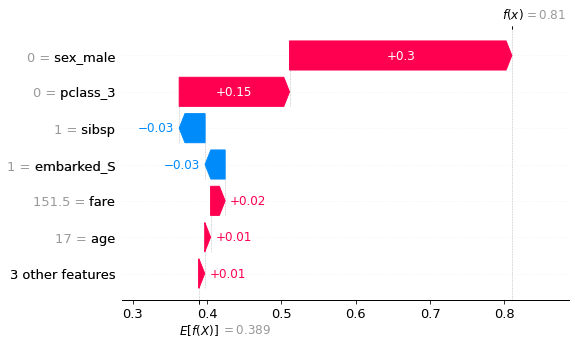

In [25]:
max_display = 7
proba = rf.predict_proba(X_test.loc[idx].to_numpy().reshape(1,-1))
print(f"Survived proba for {idx} is {proba[0][1]}.\nWaterfall plot of features contributions for class 1 (survived) :")
shap.waterfall_plot(explainer.expected_value[1], shap_values[1], X_test.loc[idx],max_display=max_display)

In [32]:
# Basic display of the most contributing features (based on shap values)
# This is basically a textual version of Shap waterfall_plot
def basic_explain(shap_values, features, expected_value, max_display = 7, print_pred = False):
    feature_names = list(features.index)
    feature_order = np.argsort(-np.abs(shap_values))
    feature_inds = feature_order[:max_display]
    pred = expected_value + np.sum(shap_values)
    cum_contrib = 0
    if print_pred:
        print(f"Prediction is: {pred:.2}\n")
    print("Most contributing features* :")
    for i in feature_inds:
        cum_contrib += shap_values[i]
        s=f"{feature_names[i]}={features[i]:.3}"
        print(f"{s:>30}  -> {shap_values[i]:.2}")                
    s=f"{len(shap_values)-max_display} other features"
    print(f"{s:>30}  -> {np.sum(shap_values)-cum_contrib:.2}")
    print(f"\n* compared to avg pred : {expected_value:.2}")

In [43]:
#Explain proba for class 1
max_display = 8
print(f"Features contributions to have proba of {proba[0][1]} for class 1 (benign) for this data:\n")
basic_explain(shap_values[1], X_test.loc[idx], explainer.expected_value[1], max_display=max_display)

Features contributions to have proba of 0.81 for class 1 (benign) for this data:

Most contributing features* :
                  sex_male=0.0  -> 0.3
                  pclass_3=0.0  -> 0.15
                     sibsp=1.0  -> -0.035
                embarked_S=1.0  -> -0.027
                 fare=1.52e+02  -> 0.02
                      age=17.0  -> 0.0078
                     parch=1.0  -> 0.0043
                  pclass_2=0.0  -> 0.0041
              1 other features  -> -0.00017

* compared to avg pred : 0.39


In [54]:
%%time
#For all test value
#print(X_test.loc[idx])
shap_values = explainer.shap_values(X_test)

Wall time: 110 ms


In [55]:
%%time
#Compute SHAP values
idx = 'Jack'
#print(X_test.loc[idx])
shap_values = explainer.shap_values(X_test.loc[idx])

Wall time: 33.9 ms


In [50]:
print(f"Features contributions to have proba of {proba[0][1]} for class 1 (benign) for this data:\n")
basic_explain(shap_values[1], X_test.loc[idx], explainer.expected_value[1], max_display=max_display)

Features contributions to have proba of 0.81 for class 1 (benign) for this data:

Most contributing features* :
                  sex_male=1.0  -> -0.11
                embarked_S=1.0  -> -0.064
                      age=20.0  -> -0.061
                      fare=9.5  -> -0.057
                  pclass_3=1.0  -> -0.054
                     parch=0.0  -> -0.017
                  pclass_2=0.0  -> -0.0094
                     sibsp=0.0  -> 0.0027
              1 other features  -> -0.00087

* compared to avg pred : 0.39


# Using Kernel Explainer

In [18]:
my_pred = lambda x: rf.predict_proba(x)[:,1]

In [36]:
# Difference: on utilise la fct predict_proba plutot que le modele pour la construction de l'explainer
#kexplainer = shap.KernelExplainer(my_pred, data=X.sample(100, random_state=0), link="logit")
#kexplainer = shap.KernelExplainer(my_pred, data=X.sample(100, random_state=0), link="identity")
kexplainer = shap.KernelExplainer(rf.predict_proba, data=X.sample(100, random_state=0), link="identity")

In [37]:
kexplainer.expected_value

array([0.61144395, 0.38855605])

In [44]:
%%time
#Compute SHAP values
idx = 'Rose'
#print(X_test.loc[idx])
shap_values = kexplainer.shap_values(X_test.loc[idx], l1_reg="aic")

Wall time: 441 ms


In [52]:
%%time
#Compute SHAP values (for all X_test data)
#print(X_test.loc[idx])
shap_values = kexplainer.shap_values(X_test, l1_reg="aic")


Wall time: 2 s


In [46]:
#Explain proba for class 1
max_display = 8
print(f"Features contributions to have proba of {proba[0][1]} for class 1 (benign) for this data:\n")
basic_explain(shap_values[1], X_test.loc[idx], explainer.expected_value[1], max_display=max_display)

Features contributions to have proba of 0.81 for class 1 (benign) for this data:

Most contributing features* :
                  sex_male=0.0  -> 0.3
                  pclass_3=0.0  -> 0.15
                     sibsp=1.0  -> -0.033
                embarked_S=1.0  -> -0.026
                 fare=1.52e+02  -> 0.021
                      age=17.0  -> 0.0092
                     parch=1.0  -> 0.0
                  pclass_2=0.0  -> 0.0
              1 other features  -> 0.0

* compared to avg pred : 0.39


Survived proba for Rose is 0.81.
Waterfall plot of features contributions for class 1 (survived) :


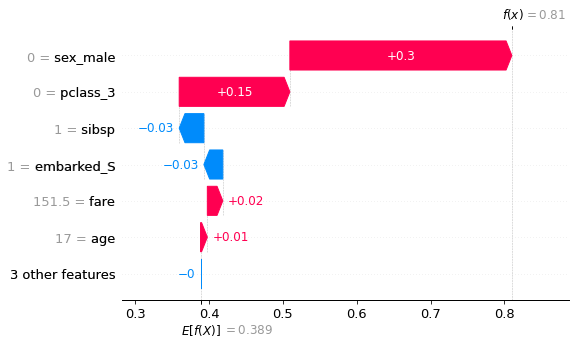

In [22]:
max_display = 7
proba = rf.predict_proba(X_test.loc[idx].to_numpy().reshape(1,-1))
print(f"Survived proba for {idx} is {proba[0][1]}.\nWaterfall plot of features contributions for class 1 (survived) :")
shap.waterfall_plot(kexplainer.expected_value[1], shap_values[1], X_test.loc[idx],max_display=max_display)

In [47]:
%%time
#Compute SHAP values
idx = 'Jack'
#print(X_test.loc[idx])
shap_values = kexplainer.shap_values(X_test.loc[idx], l1_reg="aic")

Wall time: 506 ms


In [48]:
#Explain proba for class 1
max_display = 8
print(f"Features contributions to have proba of {proba[0][1]} for class 1 (benign) for this data:\n")
basic_explain(shap_values[1], X_test.loc[idx], explainer.expected_value[1], max_display=max_display)

Features contributions to have proba of 0.81 for class 1 (benign) for this data:

Most contributing features* :
                  sex_male=1.0  -> -0.11
                embarked_S=1.0  -> -0.064
                      age=20.0  -> -0.06
                      fare=9.5  -> -0.057
                  pclass_3=1.0  -> -0.054
                     parch=0.0  -> -0.016
                  pclass_2=0.0  -> -0.0091
                     sibsp=0.0  -> 0.0
              1 other features  -> -5.6e-17

* compared to avg pred : 0.39


# Conclusion Kernel vs Tree Explainer
Tree explainer is indeed much faster than Kernel explainer (probably due to its C++ implementation).

Approx 10 times faster for a single SHAP computation with Tree explainer on my local PC (~ 35ms per prediction).

But, Kernel explainer execution time still remains reasonable for few predictions.
Also, there are some slight differences in the resulting values. But, the difference is in the order of 10exp-3.
So, Tree Shap is better for Tree based model but Kernel Shap seems really acceptable to explain few predictions.

# Test with random proba function
I test (kernel) explainer with a predict proba function returning a random probability.

In [101]:
#Random predict proba function
def my_pred(x):
    return np.random.rand(len(x),2)
    

In [102]:
#Test with making a prediction for a test element
my_pred(X_test.loc[idx].to_numpy().reshape(1,-1))

array([[0.88049891, 0.79410867]])

In [103]:
kexplainer = shap.KernelExplainer(my_pred, data=X.sample(100, random_state=0), link="identity")

In [104]:
kexplainer.expected_value

array([0.47276741, 0.52912592])

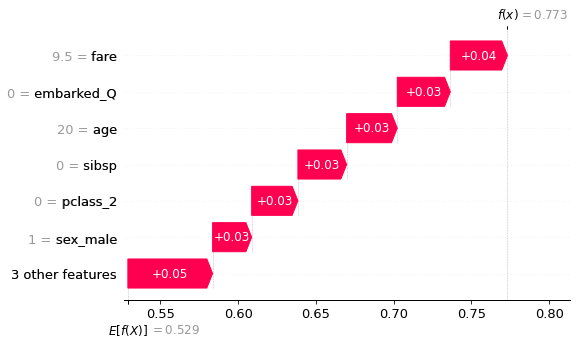

In [106]:
shap_values = kexplainer.shap_values(X_test.loc[idx], check_additivity=False)
max_display = 7
shap.waterfall_plot(kexplainer.expected_value[1], shap_values[1], X_test.loc[idx],max_display=max_display)